In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm, uniform

In [5]:
df = pd.read_csv('../data/3_fill_nans/processed_data.csv')

In [13]:
df['zone']

0              Cold
1              Cold
2           Hot-Dry
3            Marine
4            Marine
           ...     
8129        Hot-Dry
8130        Hot-Dry
8131    Mixed-Humid
8132      Very Cold
8133    Mixed-Humid
Name: zone, Length: 8134, dtype: object

In [21]:
df_zones_cause = pd.DataFrame(df.groupby(by='zone')['CAUSE'].apply(lambda gr_df: gr_df.value_counts()))
opt_max_col = pd.get_option('display.max_rows')
pd.set_option('display.max_rows', df_zones_cause.shape[0])
display(df_zones_cause)
pd.set_option('display.max_rows', opt_max_col)

CAUSE
zone                                               
Cold        EQUIPMENT FAILURE                   664
            EXCAVATION DAMAGE                   251
            INCORRECT OPERATION                 221
            OTHER OUTSIDE FORCE DAMAGE          197
            CORROSION FAILURE                   184
            NATURAL FORCE DAMAGE                152
            MATERIAL FAILURE OF PIPE OR WELD    136
            OTHER INCIDENT CAUSE                 51
            PIPE, WELD, OR JOINT FAILURE         37
            OTHER ACCIDENT CAUSE                 12
Hot-Dry     EQUIPMENT FAILURE                   485
            CORROSION FAILURE                   299
            INCORRECT OPERATION                 141
            EXCAVATION DAMAGE                   122
            OTHER OUTSIDE FORCE DAMAGE           88
            MATERIAL FAILURE OF PIPE OR WELD     45
            NATURAL FORCE DAMAGE                 28
            PIPE, WELD, OR JOINT FAILURE         18
            OTHER ACCIDENT CAUSE                 17
            OTHER INCIDENT CAUSE                  5
Hot-Humid   EQUIPMENT FAILURE                   919
            CORROSION FAILURE                   580
            INCORRECT OPERATION                 304
            MATERIAL FAILURE OF PIPE OR WELD    176
            EXCAVATION DAMAGE                   153
            NATURAL FORCE DAMAGE                118
            OTHER OUTSIDE FORCE DAMAGE          108
            OTHER INCIDENT CAUSE                 43
            OTHER ACCIDENT CAUSE                 41
            PIPE, WELD, OR JOINT FAILURE         16
Marine      EXCAVATION DAMAGE                    36
            OTHER OUTSIDE FORCE DAMAGE           33
            EQUIPMENT FAILURE                    21
            INCORRECT OPERATION                  17
            CORROSION FAILURE                    12
            MATERIAL FAILURE OF PIPE OR WELD      6
            PIPE, WELD, OR JOINT FAILURE          6
            NATURAL FORCE DAMAGE                  5
Mixed-Dry   EQUIPMENT FAILURE                    63
            CORROSION FAILURE                    21
            INCORRECT OPERATION                  18
            EXCAVATION DAMAGE                     9
            NATURAL FORCE DAMAGE                  8
            MATERIAL FAILURE OF PIPE OR WELD      7
            OTHER OUTSIDE FORCE DAMAGE            7
            OTHER INCIDENT CAUSE                  5
            OTHER ACCIDENT CAUSE                  1
Mixed-Humid EQUIPMENT FAILURE                   729
            CORROSION FAILURE                   325
            INCORRECT OPERATION                 235
            EXCAVATION DAMAGE                   233
            OTHER OUTSIDE FORCE DAMAGE          179
            MATERIAL FAILURE OF PIPE OR WELD    123
            NATURAL FORCE DAMAGE                122
            OTHER INCIDENT CAUSE                 51
            OTHER ACCIDENT CAUSE                 25
            PIPE, WELD, OR JOINT FAILURE         18
Subarctic   EQUIPMENT FAILURE                     9
            INCORRECT OPERATION                   2
            CORROSION FAILURE                     2
            NATURAL FORCE DAMAGE                  2
Very Cold   EQUIPMENT FAILURE                    80
            MATERIAL FAILURE OF PIPE OR WELD     26
            NATURAL FORCE DAMAGE                 23
            INCORRECT OPERATION                  22
            CORROSION FAILURE                    16
            OTHER OUTSIDE FORCE DAMAGE           12
            EXCAVATION DAMAGE                    11
            OTHER ACCIDENT CAUSE                  2
            OTHER INCIDENT CAUSE                  1

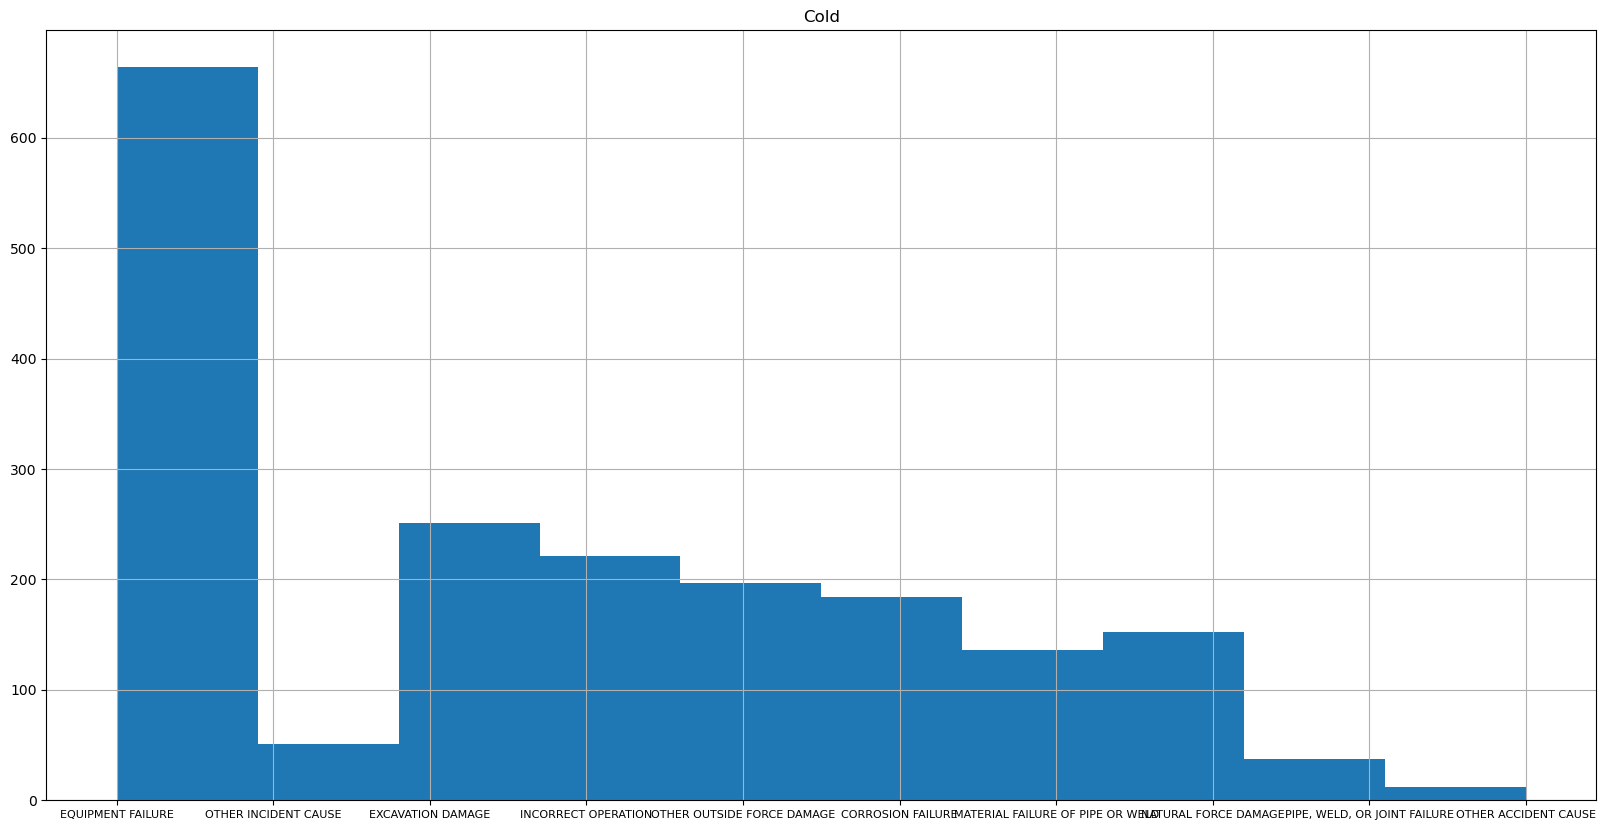

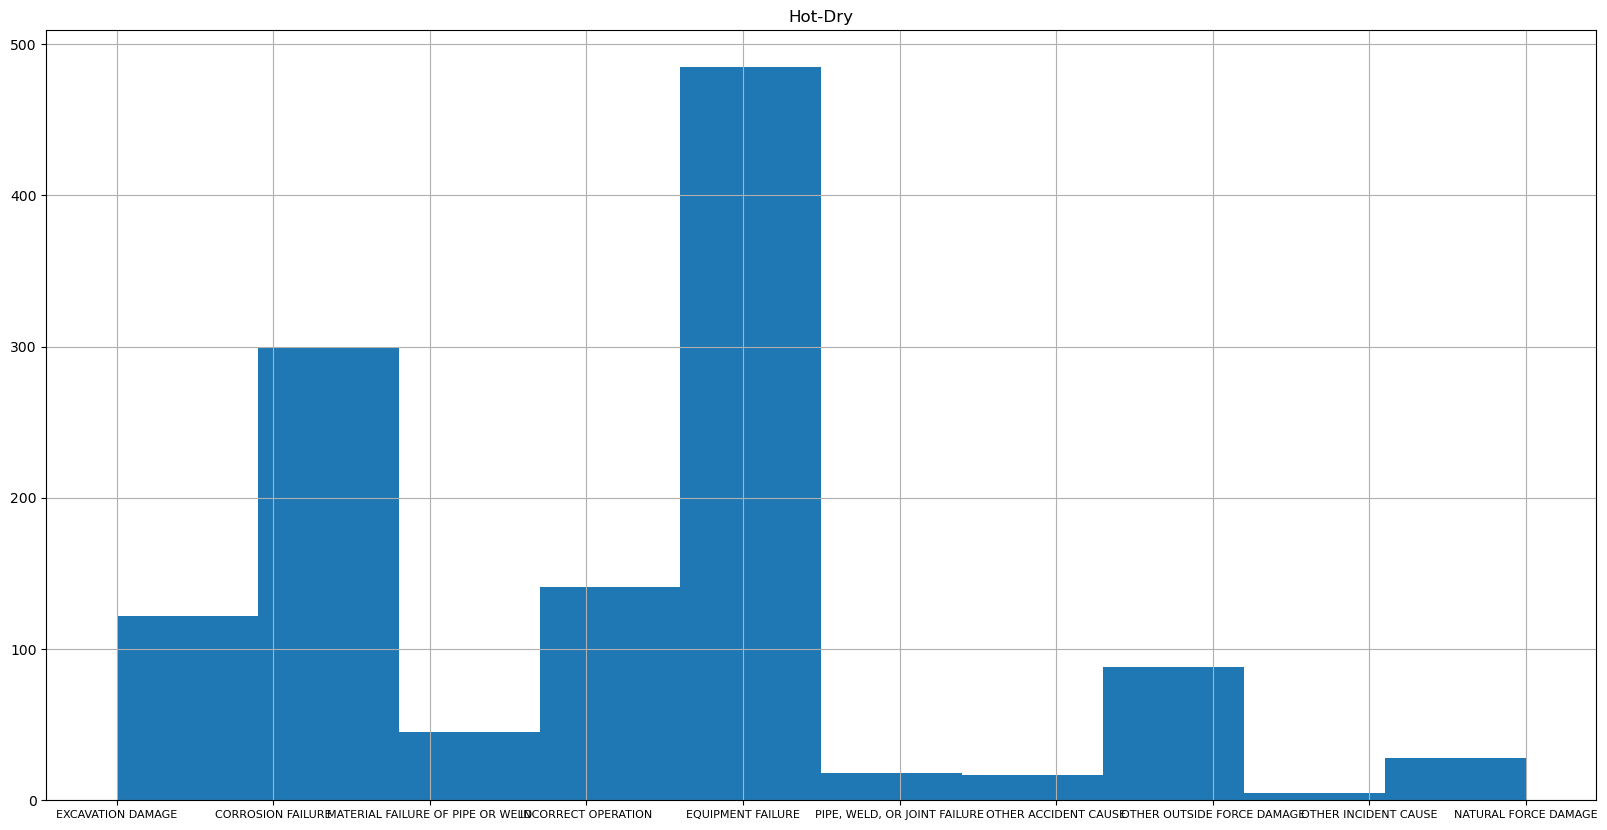

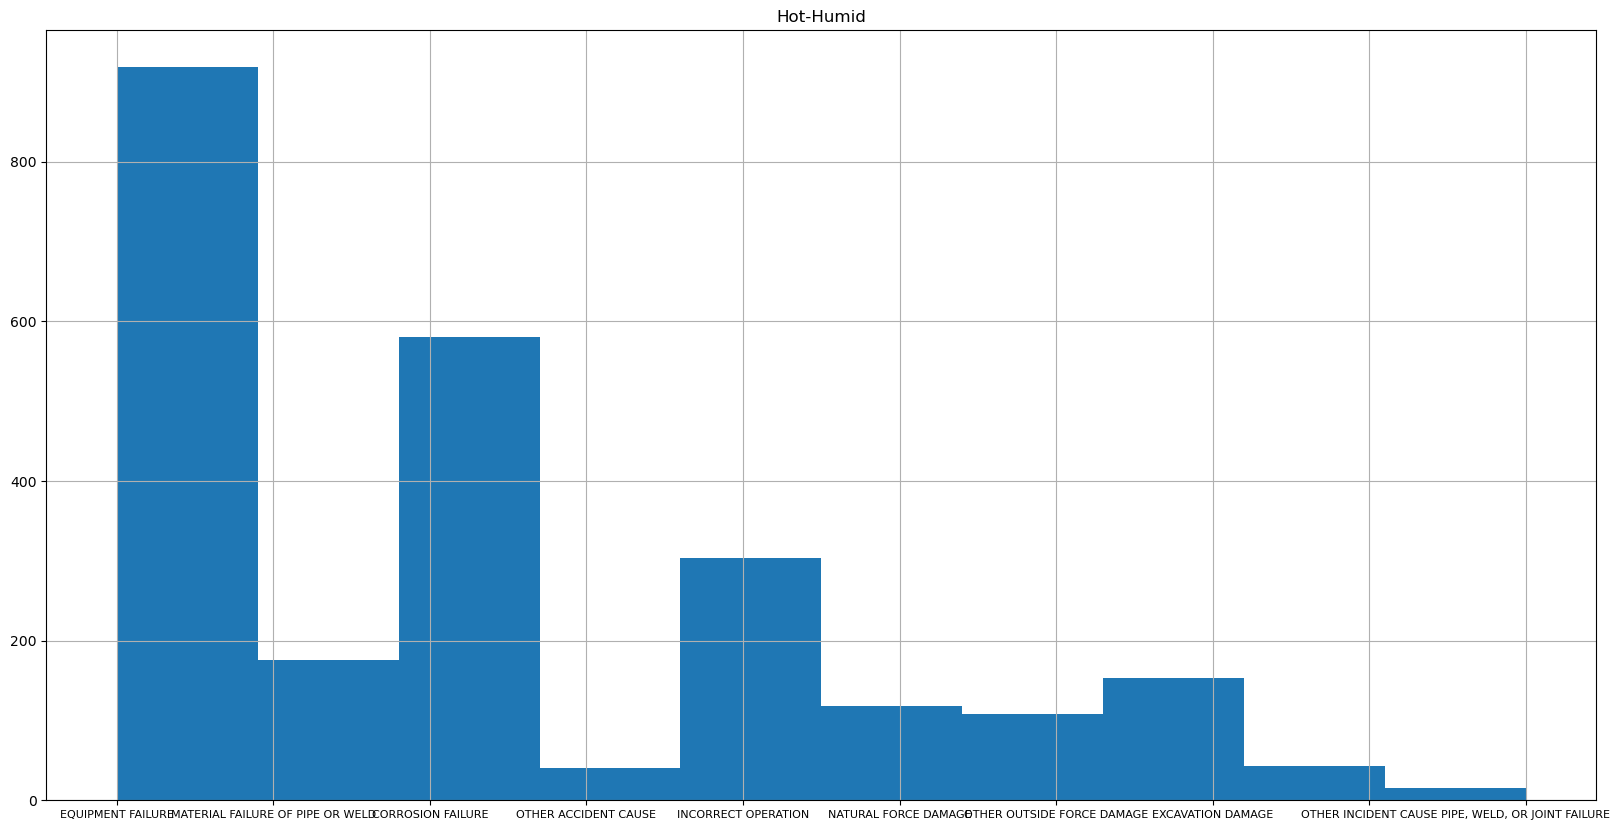

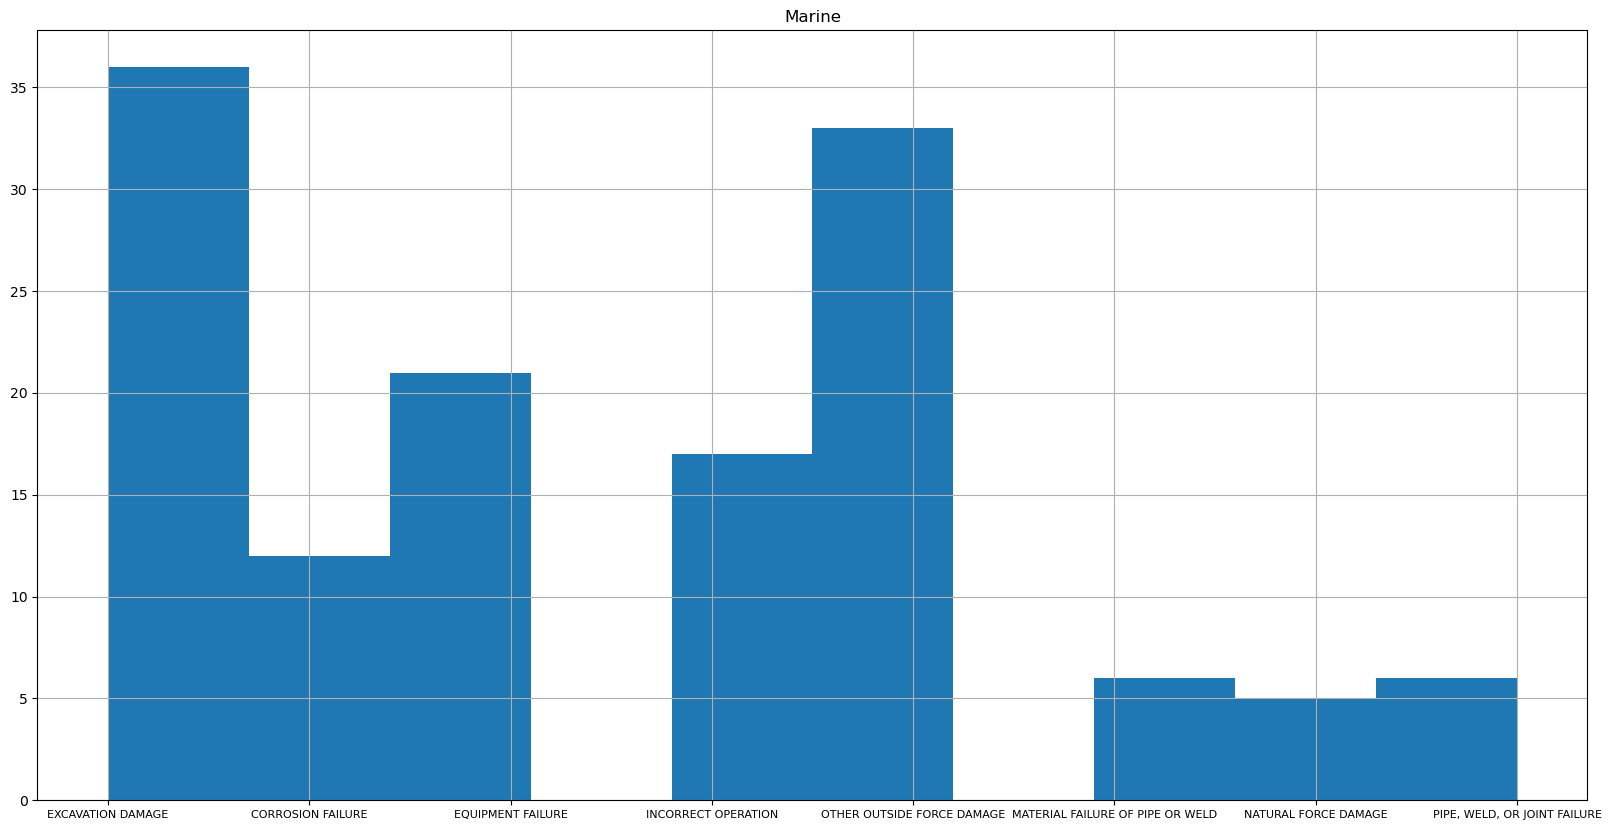

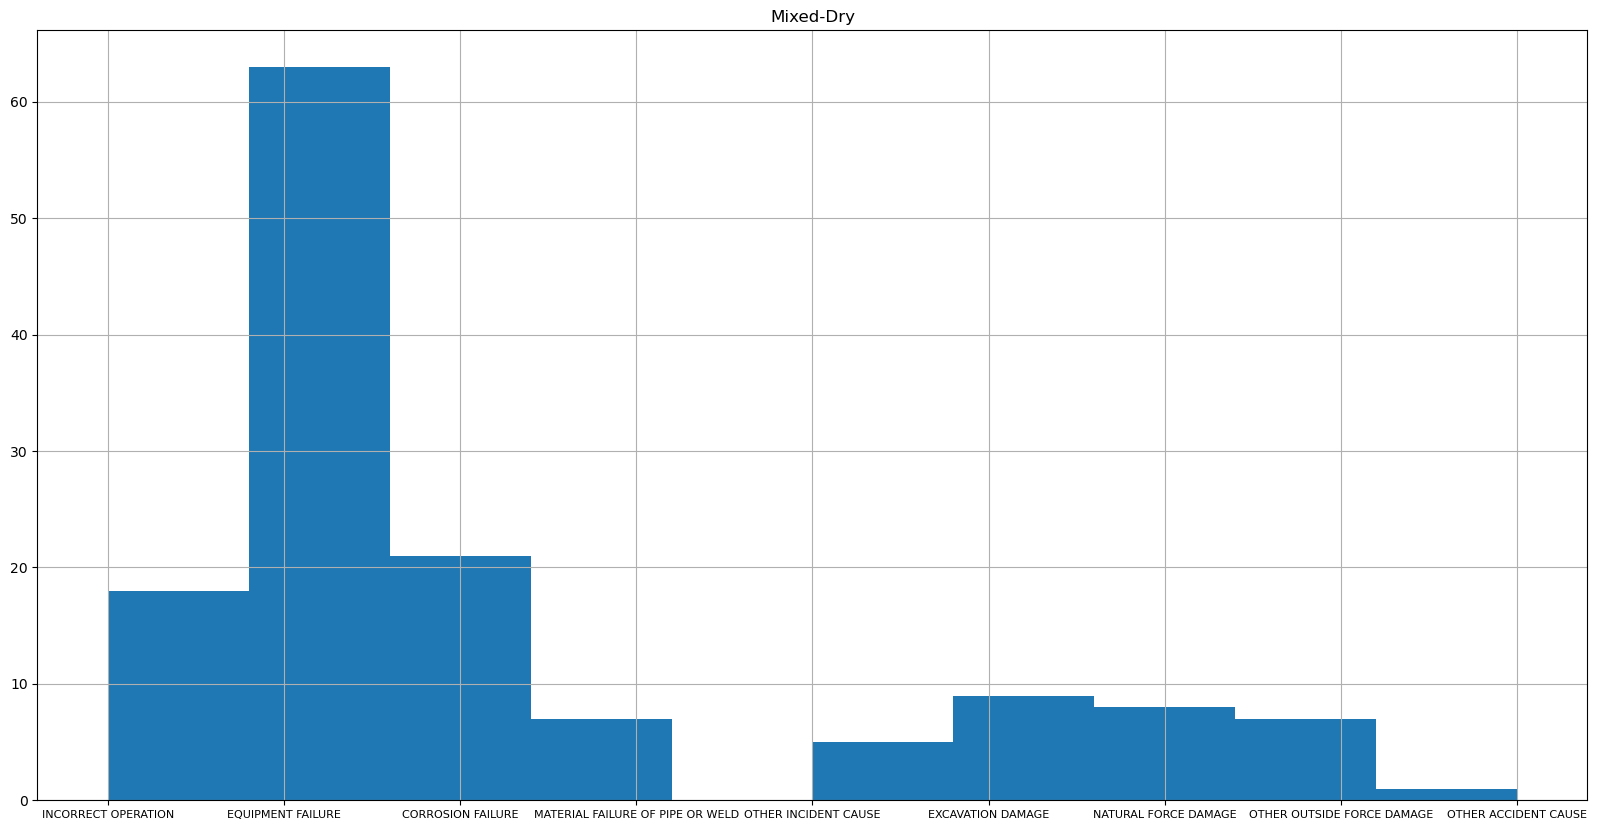

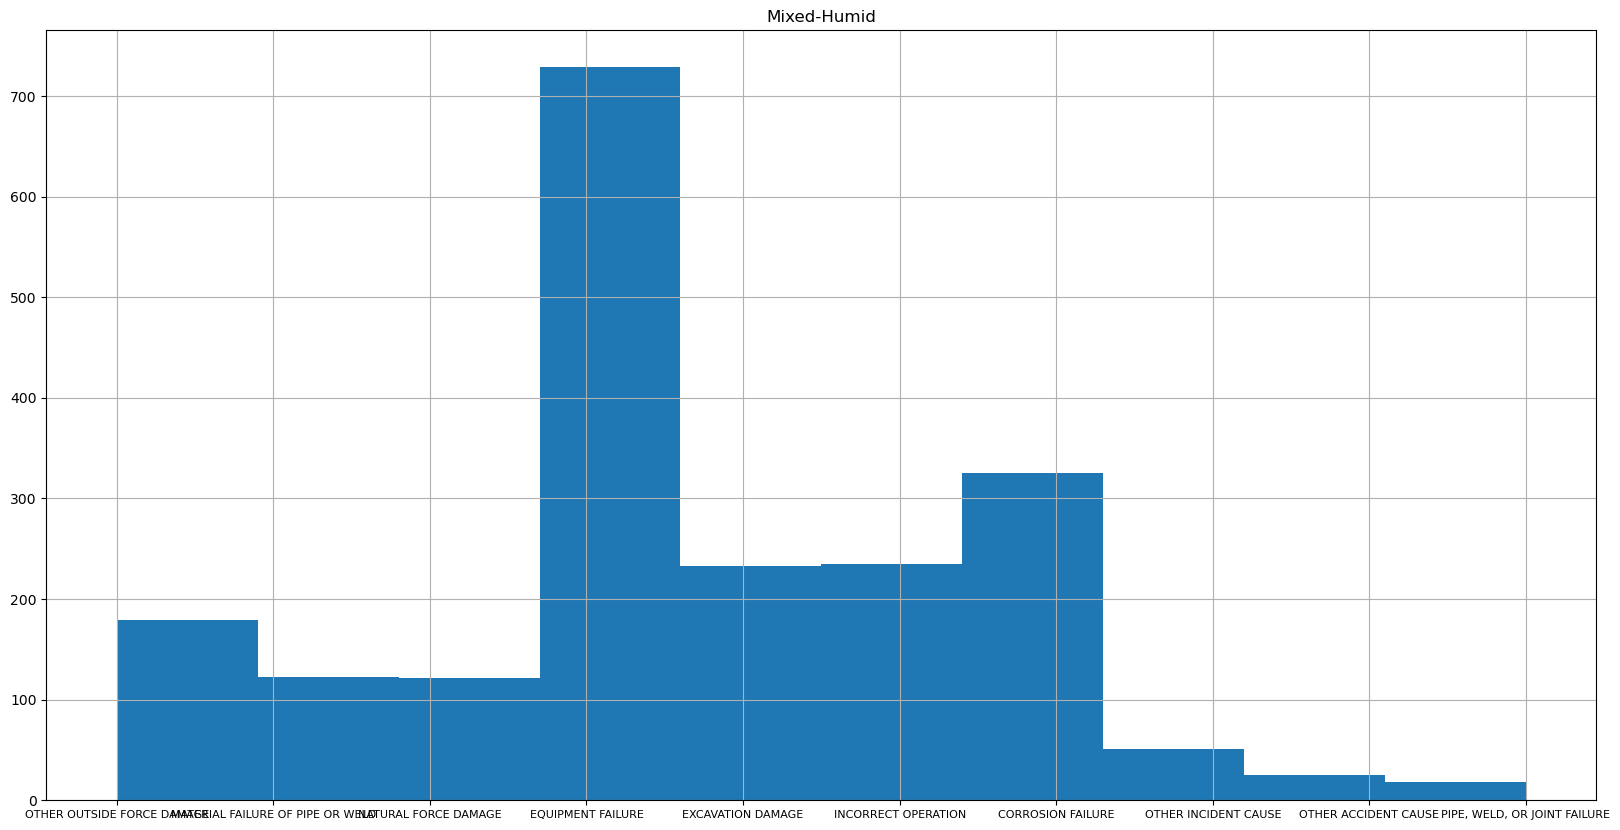

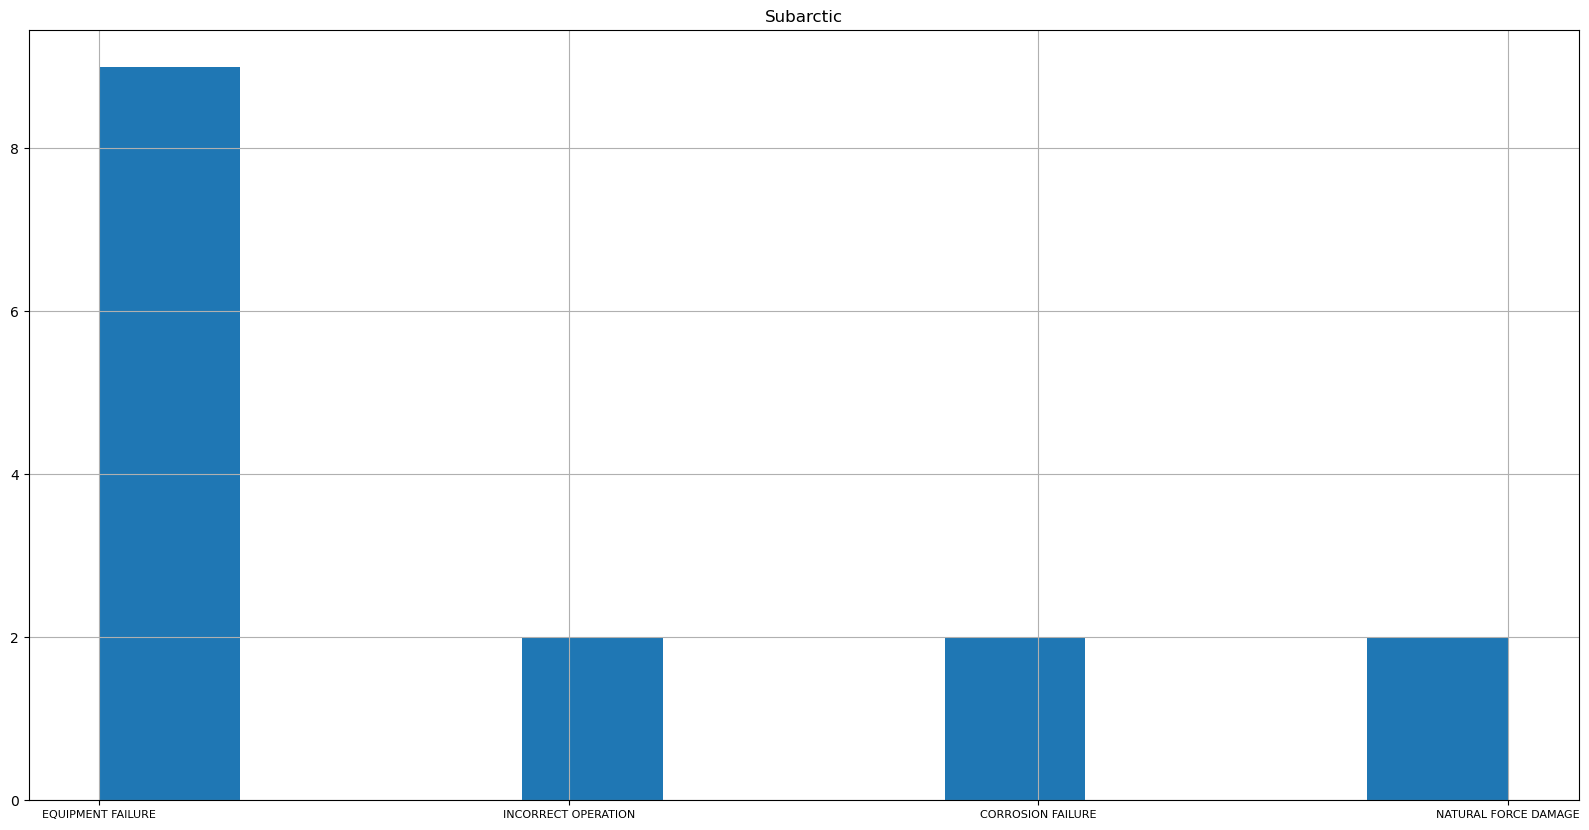

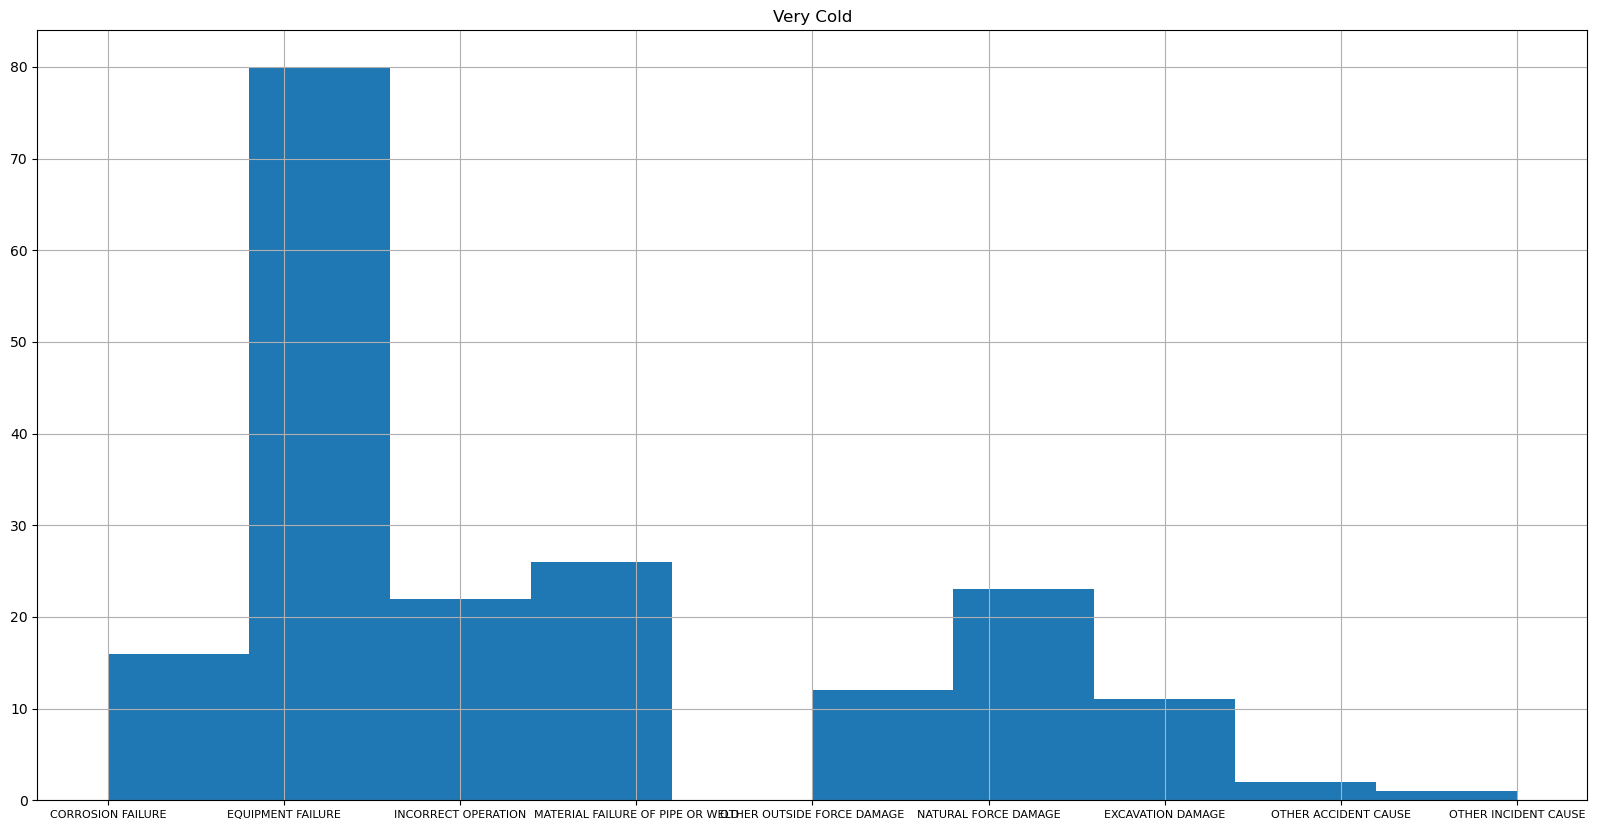

In [60]:
hists = pd.DataFrame(df.groupby(by='zone')['CAUSE'].apply(lambda gr_df: gr_df.hist))
i = 0
for index, hist in hists.iterrows():
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 10)
    ax.set_title(index)
    hist['CAUSE'](ax=ax, xlabelsize=8)
    i+=1

In [14]:
numeric_types = df.dtypes[df.dtypes == 'float64'].index.to_list()
non_numeric_types = df.dtypes[df.dtypes == 'object'].index.to_list()

In [8]:
to_process_idf = df[df[non_numeric_types].iloc[0].apply(lambda val: len(str(val).split(' ')) > 1).loc[lambda val: val].index.tolist()]
# v = TfidfVectorizer()
# processed_idf_cols = v.fit_transform(to_process_idf)
# processed_idf_cols.shape
to_process_idf['']

KeyError: ''

In [13]:
df[non_numeric_types].mode(axis=0)

,data_source,case_date,YYYY-mm_prev,rlsd_type,FATALITY_IND,INJURY_IND,ON_OFF_SHORE,IGNITE_IND,EXPLODE_IND,FEDERAL,...,INSTALLATION_YEAR,RELEASE_TYPE,COULD_BE_HCA,ACCIDENT_PRESSURE,PIPELINE_FUNCTION,SCADA_IN_PLACE_IND,INVESTIGATION_STATUS,EMPLOYEE_DRUG_TEST_IND,CONTRACTOR_DRUG_TEST_IND,zone
0,hazardous_liquid,2021-02-20,2021-01,NATURAL GAS,NO,NO,ONSHORE,NO,NO,NO,...,UNKNOWN,LEAK,NO,PRESSURE DID NOT EXCEED MOP,> 20% SMYS REGULATED TRANSMISSION,YES,"NO, THE OPERATOR DID NOT FIND THAT AN INVESTIG...",NO,NO,Hot-Humid


In [10]:
means_numeric = df[numeric_types].mean(axis=0)
modes_string = df[non_numeric_types].mode(axis=0).iloc[0]
df = df.fillna(value = (means_numeric.to_dict() | modes_string.to_dict()))

In [81]:
def display_col_stats(df: pd.DataFrame):
    # boxplot part
    numeric_columns = df.dtypes[df.dtypes == 'float64'].index.tolist()
    non_numeric_columns = df.dtypes[df.dtypes != 'float64'].index.tolist()
    fig, axs = plt.subplots(int(len(numeric_columns)/2+1), 2)
    fig.set_size_inches(50,50)
    cntr = 0
    for i in range(len(axs)):
        for j in range(len(axs[i])):
            if cntr < len(numeric_columns):
                col_name = numeric_columns[cntr]
                axs[i][j].boxplot(df[col_name], vert = False)
                axs[i][j].set_title(col_name)
                cntr+=1
    
    # histogram part
    fig1, axs1 = plt.subplots(int(len(numeric_columns)/2+1), 2)
    fig1.set_size_inches(50,50)
    cntr1 = 0
    for i in range(len(axs1)):
        for j in range(len(axs1[i])):
            if cntr1 < len(numeric_columns):
                col_name = numeric_columns[cntr1]
                axs1[i][j].hist(df[col_name], label=df[col_name].unique())
                axs1[i][j].set_title(col_name)
                cntr1+=1
    # Q-Q plot
    fig1, axs1 = plt.subplots(int(len(numeric_columns)/2+1), 2)
    fig1.set_size_inches(50,50)
    cntr1 = 0
    for i in range(len(axs1)):
        for j in range(len(axs1[i])):
            if cntr1 < len(numeric_columns):
                col_name = numeric_columns[cntr1]
                qqplot(df[col_name], norm, ax=axs1[i][j], fit=True)
                axs1[i][j].set_title(col_name)
                cntr1+=1
    

In [74]:
numeric_columns

['case_lat',
 'case_lon',
 'FATAL',
 'INJURE',
 'NUM_PUB_EVACUATED',
 'EST_COST_OPER_PAID',
 'EST_COST_PROP_DAMAGE',
 'EST_COST_EMERGENCY',
 'EST_COST_OTHER',
 'ACCIDENT_PSIG',
 'MOP_PSIG',
 'TAVG',
 'TMAX',
 'TMIN',
 'TAVG_prev',
 'TMAX_prev',
 'TMIN_prev']

In [54]:
pd.set_option('display.max_columns', None)

In [55]:
def display_outliers(df, col_name):
    display(df.loc[(df[col_name] > df[col_name].mean() + 3 * df[col_name].std()) | (df[col_name] < df[col_name].mean() - 3 * df[col_name].std())])

In [73]:
numeric_columns = df.dtypes[df.dtypes == 'float64'].index.tolist()
display_outliers(df, numeric_columns[16])

,data_source,case_lat,case_lon,case_date,YYYY-mm_prev,rlsd_type,FATALITY_IND,FATAL,INJURY_IND,INJURE,ON_OFF_SHORE,IGNITE_IND,EXPLODE_IND,NUM_PUB_EVACUATED,FEDERAL,LOCATION_TYPE,CROSSING,ITEM_INVOLVED,MATERIAL_INVOLVED,EST_COST_OPER_PAID,EST_COST_PROP_DAMAGE,EST_COST_EMERGENCY,EST_COST_OTHER,CAUSE,CAUSE_DETAILS,NARRATIVE,SYSTEM_PART_INVOLVED,INCIDENT_AREA_TYPE,PIPE_FACILITY_TYPE,INSTALLATION_YEAR,RELEASE_TYPE,COULD_BE_HCA,ACCIDENT_PSIG,MOP_PSIG,ACCIDENT_PRESSURE,PIPELINE_FUNCTION,SCADA_IN_PLACE_IND,INVESTIGATION_STATUS,EMPLOYEE_DRUG_TEST_IND,CONTRACTOR_DRUG_TEST_IND,zone,TAVG,TMAX,TMIN,TAVG_prev,TMAX_prev,TMIN_prev
442,hazardous_liquid,47.690151,-95.408527,2022-03-01,2022-02,CRUDE OIL,NO,0.0,NO,0.0,ONSHORE,NO,NO,0.000000,NO,TOTALLY CONTAINED ON OPERATOR-CONTROLLED PROPERTY,NO,PUMP,CARBON STEEL,0.0,37880.0,8925.0,0.0,EQUIPMENT FAILURE,PUMP OR PUMP-RELATED EQUIPMENT,"ON MARCH 1, 2022 AT APPROXIMATELY 10:54 PM CST...",ONSHORE TERMINAL/TANK FARM EQUIPMENT AND PIPING,ABOVEGROUND,INTERSTATE,2021,LEAK,YES,136.00000,1440.00000,PRESSURE DID NOT EXCEED MOP,> 20% SMYS REGULATED TRANSMISSION,YES,"NO, THE OPERATOR DID NOT FIND THAT AN INVESTIG...",NO,NO,Very Cold,-5.63,-0.46,-10.80,-17.67,-10.58,-24.75
739,hazardous_liquid,48.805078,-103.617502,2021-03-20,2021-02,CRUDE OIL,NO,0.0,NO,0.0,ONSHORE,NO,NO,0.000000,NO,TOTALLY CONTAINED ON OPERATOR-CONTROLLED PROPERTY,NO,VALVE,CARBON STEEL,0.0,15000.0,2300.0,30000.0,CORROSION FAILURE,INTERNAL CORROSION,"ON MARCH 20, 2021 A LEAK WAS DISCOVERED BY OPE...",ONSHORE TERMINAL/TANK FARM EQUIPMENT AND PIPING,"TANK, INCLUDING ATTACHED APPURTENANCES",INTRASTATE,2015,LEAK,NO,14.50000,285.00000,PRESSURE DID NOT EXCEED MOP,=< 20% SMYS REGULATED GATHERING,NO,"YES, SPECIFY INVESTIGATION RESULT(S): (SELECT ...",NO,NO,Very Cold,0.51,7.99,-6.96,-17.51,-11.37,-23.66
742,hazardous_liquid,48.228440,-101.367200,2021-03-18,2021-02,REFINED AND/OR PETROLEUM PRODUCT (NON-HVL) WHI...,NO,0.0,NO,0.0,ONSHORE,NO,NO,0.000000,NO,TOTALLY CONTAINED ON OPERATOR-CONTROLLED PROPERTY,NO,OTHER,MATERIAL OTHER THAN CARBON STEEL,0.0,500.0,500.0,500.0,EQUIPMENT FAILURE,NON-THREADED CONNECTION FAILURE,"AT NOON CST ON 3/18/21, CENEX PERSONNEL PERFOR...",ONSHORE TERMINAL/TANK FARM EQUIPMENT AND PIPING,ABOVEGROUND,INTERSTATE,2020,LEAK,YES,30.00000,250.00000,PRESSURE DID NOT EXCEED MOP,> 20% SMYS REGULATED TRANSMISSION,YES,"NO, THE OPERATOR DID NOT FIND THAT AN INVESTIG...",NO,NO,Very Cold,1.53,8.73,-5.66,-16.46,-10.99,-21.92
1469,hazardous_liquid,48.272790,-103.360108,2019-03-07,2019-02,CRUDE OIL,NO,0.0,NO,0.0,ONSHORE,NO,NO,0.000000,NO,TOTALLY CONTAINED ON OPERATOR-CONTROLLED PROPERTY,NO,PUMP,MATERIAL OTHER THAN CARBON STEEL,0.0,3600.0,35.0,150.0,EQUIPMENT FAILURE,PUMP OR PUMP-RELATED EQUIPMENT,ON 03/07/19 AT 4:56 PM SUMMIT'S CONTROL CENTER...,ONSHORE PUMP/METER STATION EQUIPMENT AND PIPING,ABOVEGROUND,INTRASTATE,2013,LEAK,YES,52.00000,729.00000,PRESSURE DID NOT EXCEED MOP,> 20% SMYS REGULATED TRANSMISSION,YES,"YES, SPECIFY INVESTIGATION RESULT(S): (SELECT ...",NO,NO,Very Cold,-3.88,2.12,-9.87,-18.90,-15.04,-22.76
1475,hazardous_liquid,46.755689,-109.857509,2019-03-04,2019-02,CRUDE OIL,NO,0.0,NO,0.0,ONSHORE,NO,NO,0.000000,NO,"ORIGINATED ON OPERATOR-CONTROLLED PROPERTY, BU...",NO,FLANGE ASSEMBLY,MATERIAL OTHER THAN CARBON STEEL,10000.0,15000.0,200000.0,1000.0,EQUIPMENT FAILURE,NON-THREADED CONNECTION FAILURE,AT 17:08 ON 3/4/19 THE PILOT CONTACTED LOCAL O...,ONSHORE PUMP/METER STATION EQUIPMENT AND PIPING,ABOVEGROUND,INTRASTATE,2001,LEAK,NO,125.00000,1480.00000,PRESSURE DID NOT EXCEED MOP,> 20% SMYS REGULATED TRANSMISSION,YES,"NO, THE OPERATOR DID NOT FIND THAT AN INVESTIG...",NO,NO,Cold,-4.86,1.20,-10.92,-16.29,-10.44,-22.15
1870,hazardous_liquid,47.963000,-102.463500,2018-03-15,2018-02,CRUDE OIL,NO,0.0,NO,0.0,ONSHORE,NO,NO,0.000000,NO,TOTALLY CONTAINED ON OPERATOR-CONTROLLED PROPERTY,NO,AUXILIARY PIPING (E.G. DRAIN LINES),CARBON STEEL,0.0,1500.0,1000.0,0.0,EQUIPMENT FAILURE,THREADED CONNECTION/COUPLING FAILURE,OPERATIONS PERSONNEL DISCOVERED AN

In [29]:
df[numeric_columns[1]].mean()

-95.35018358423409

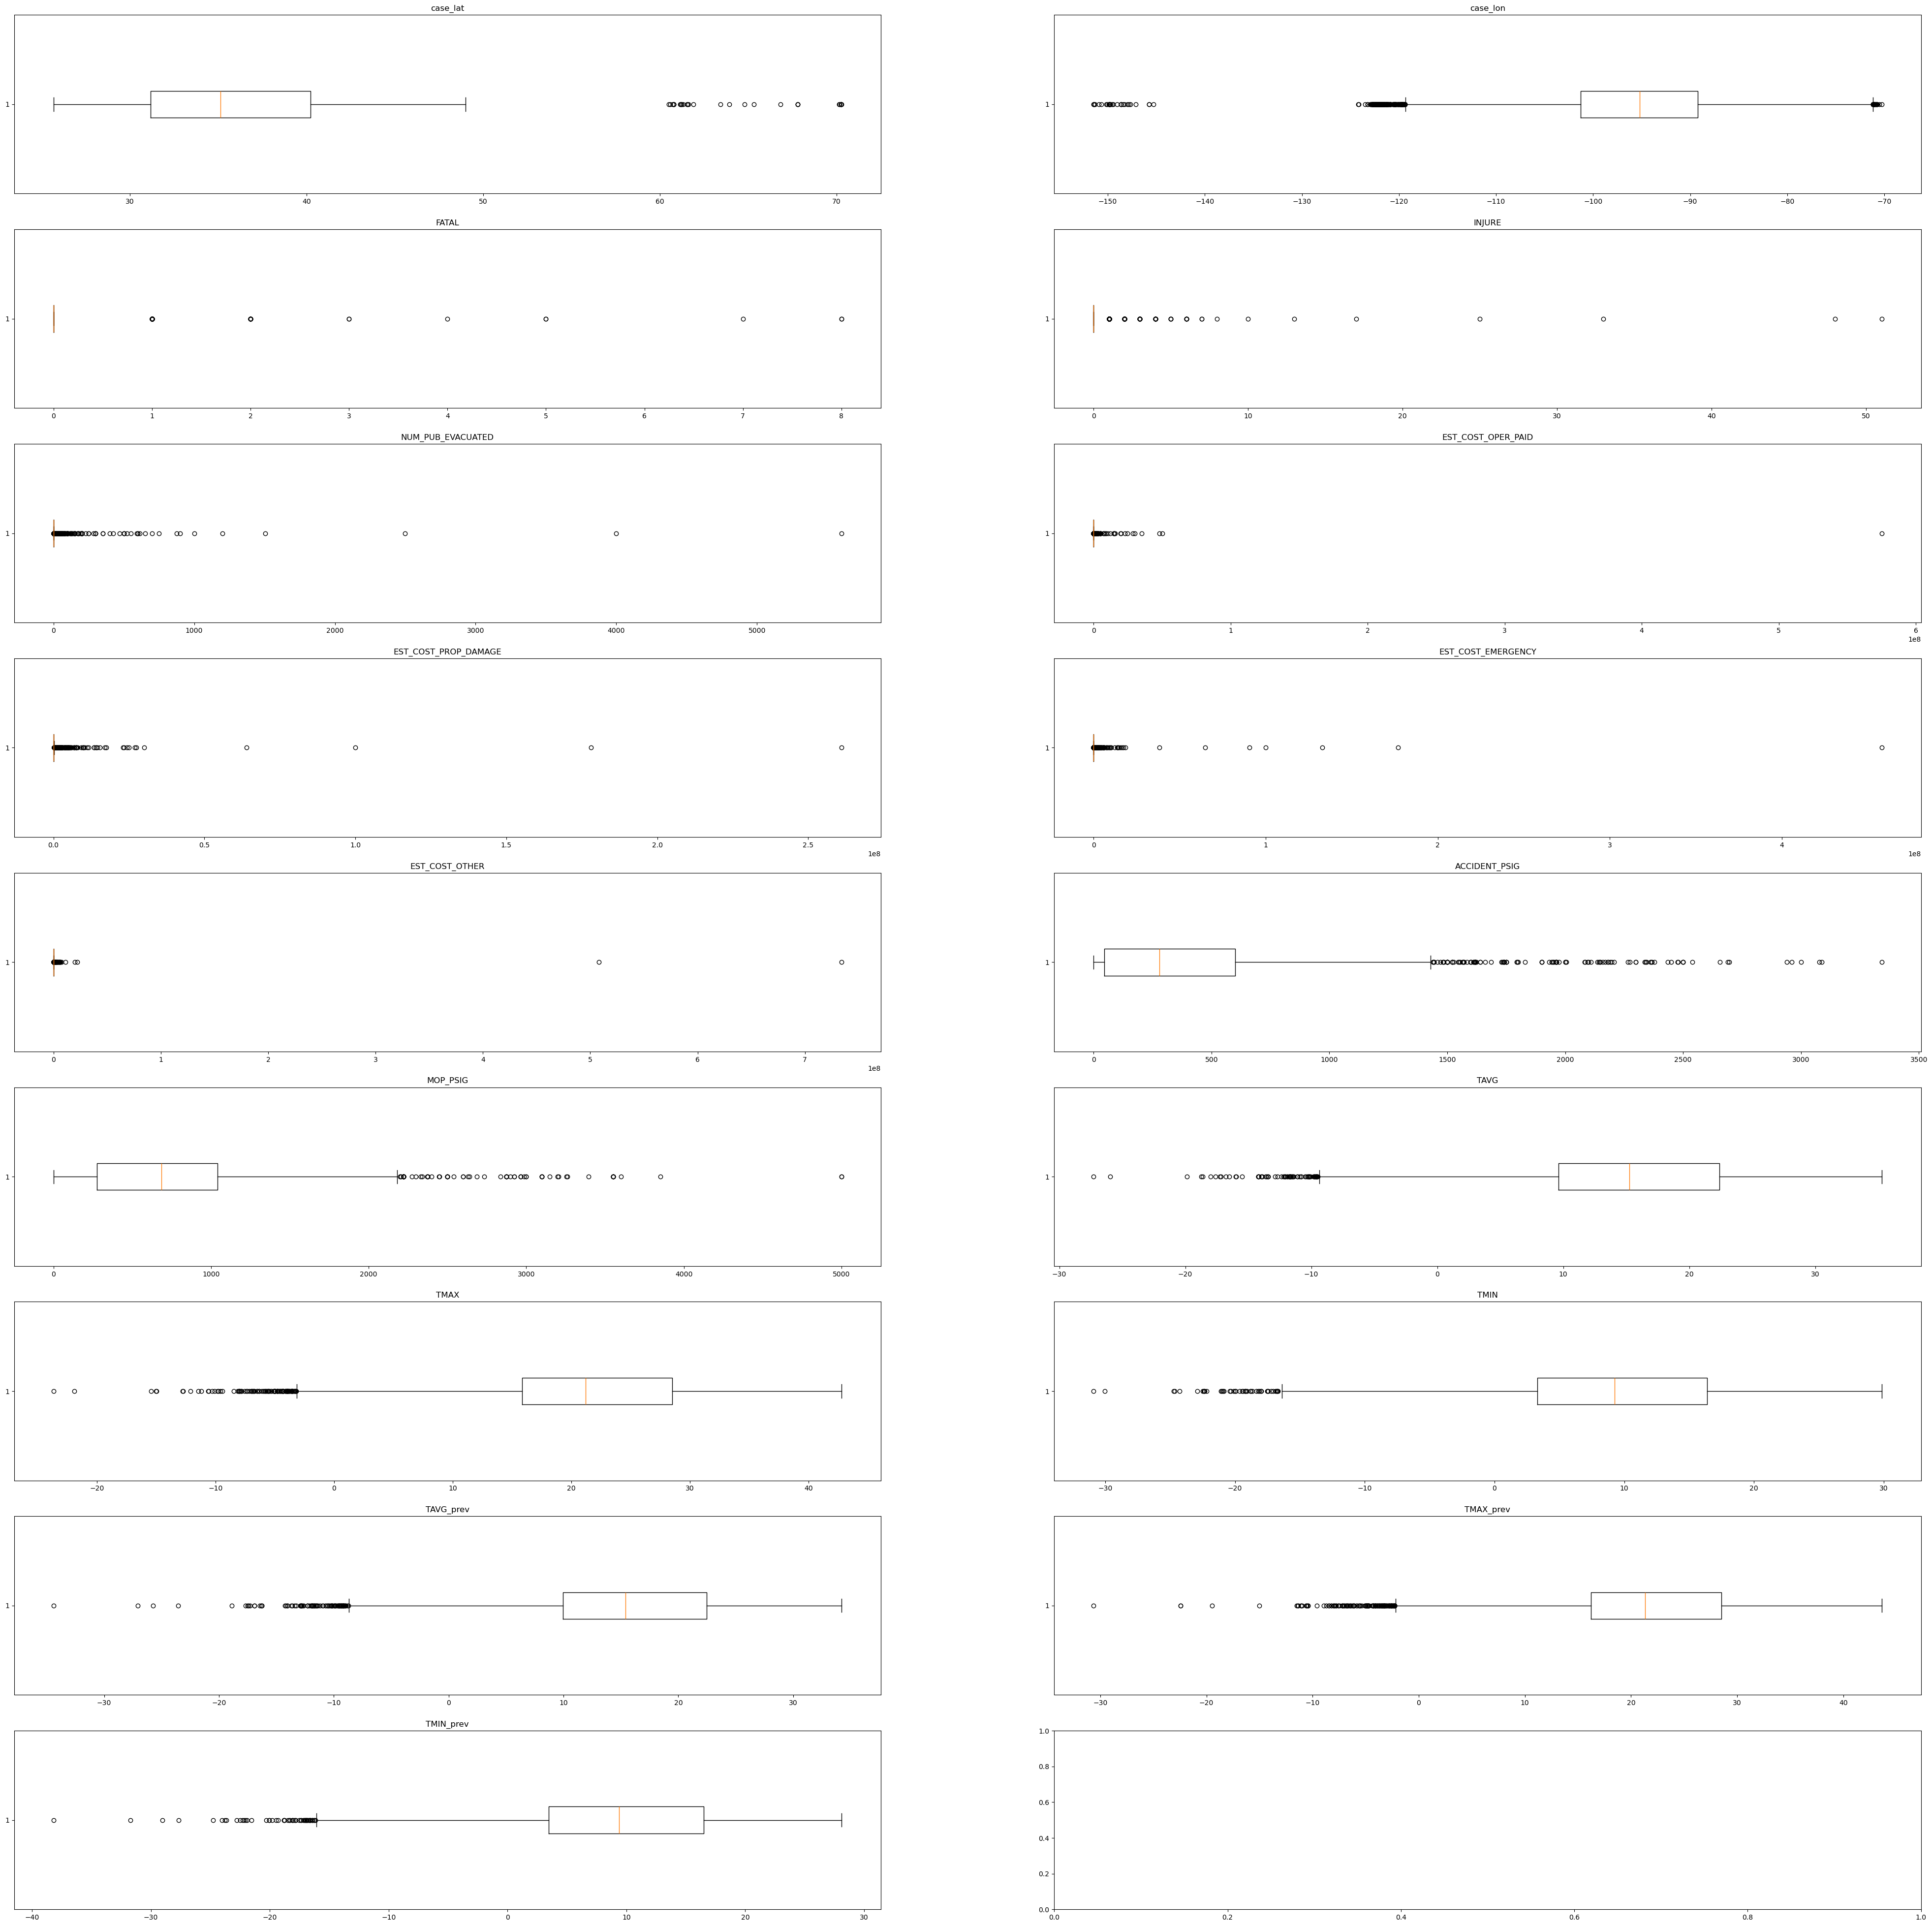

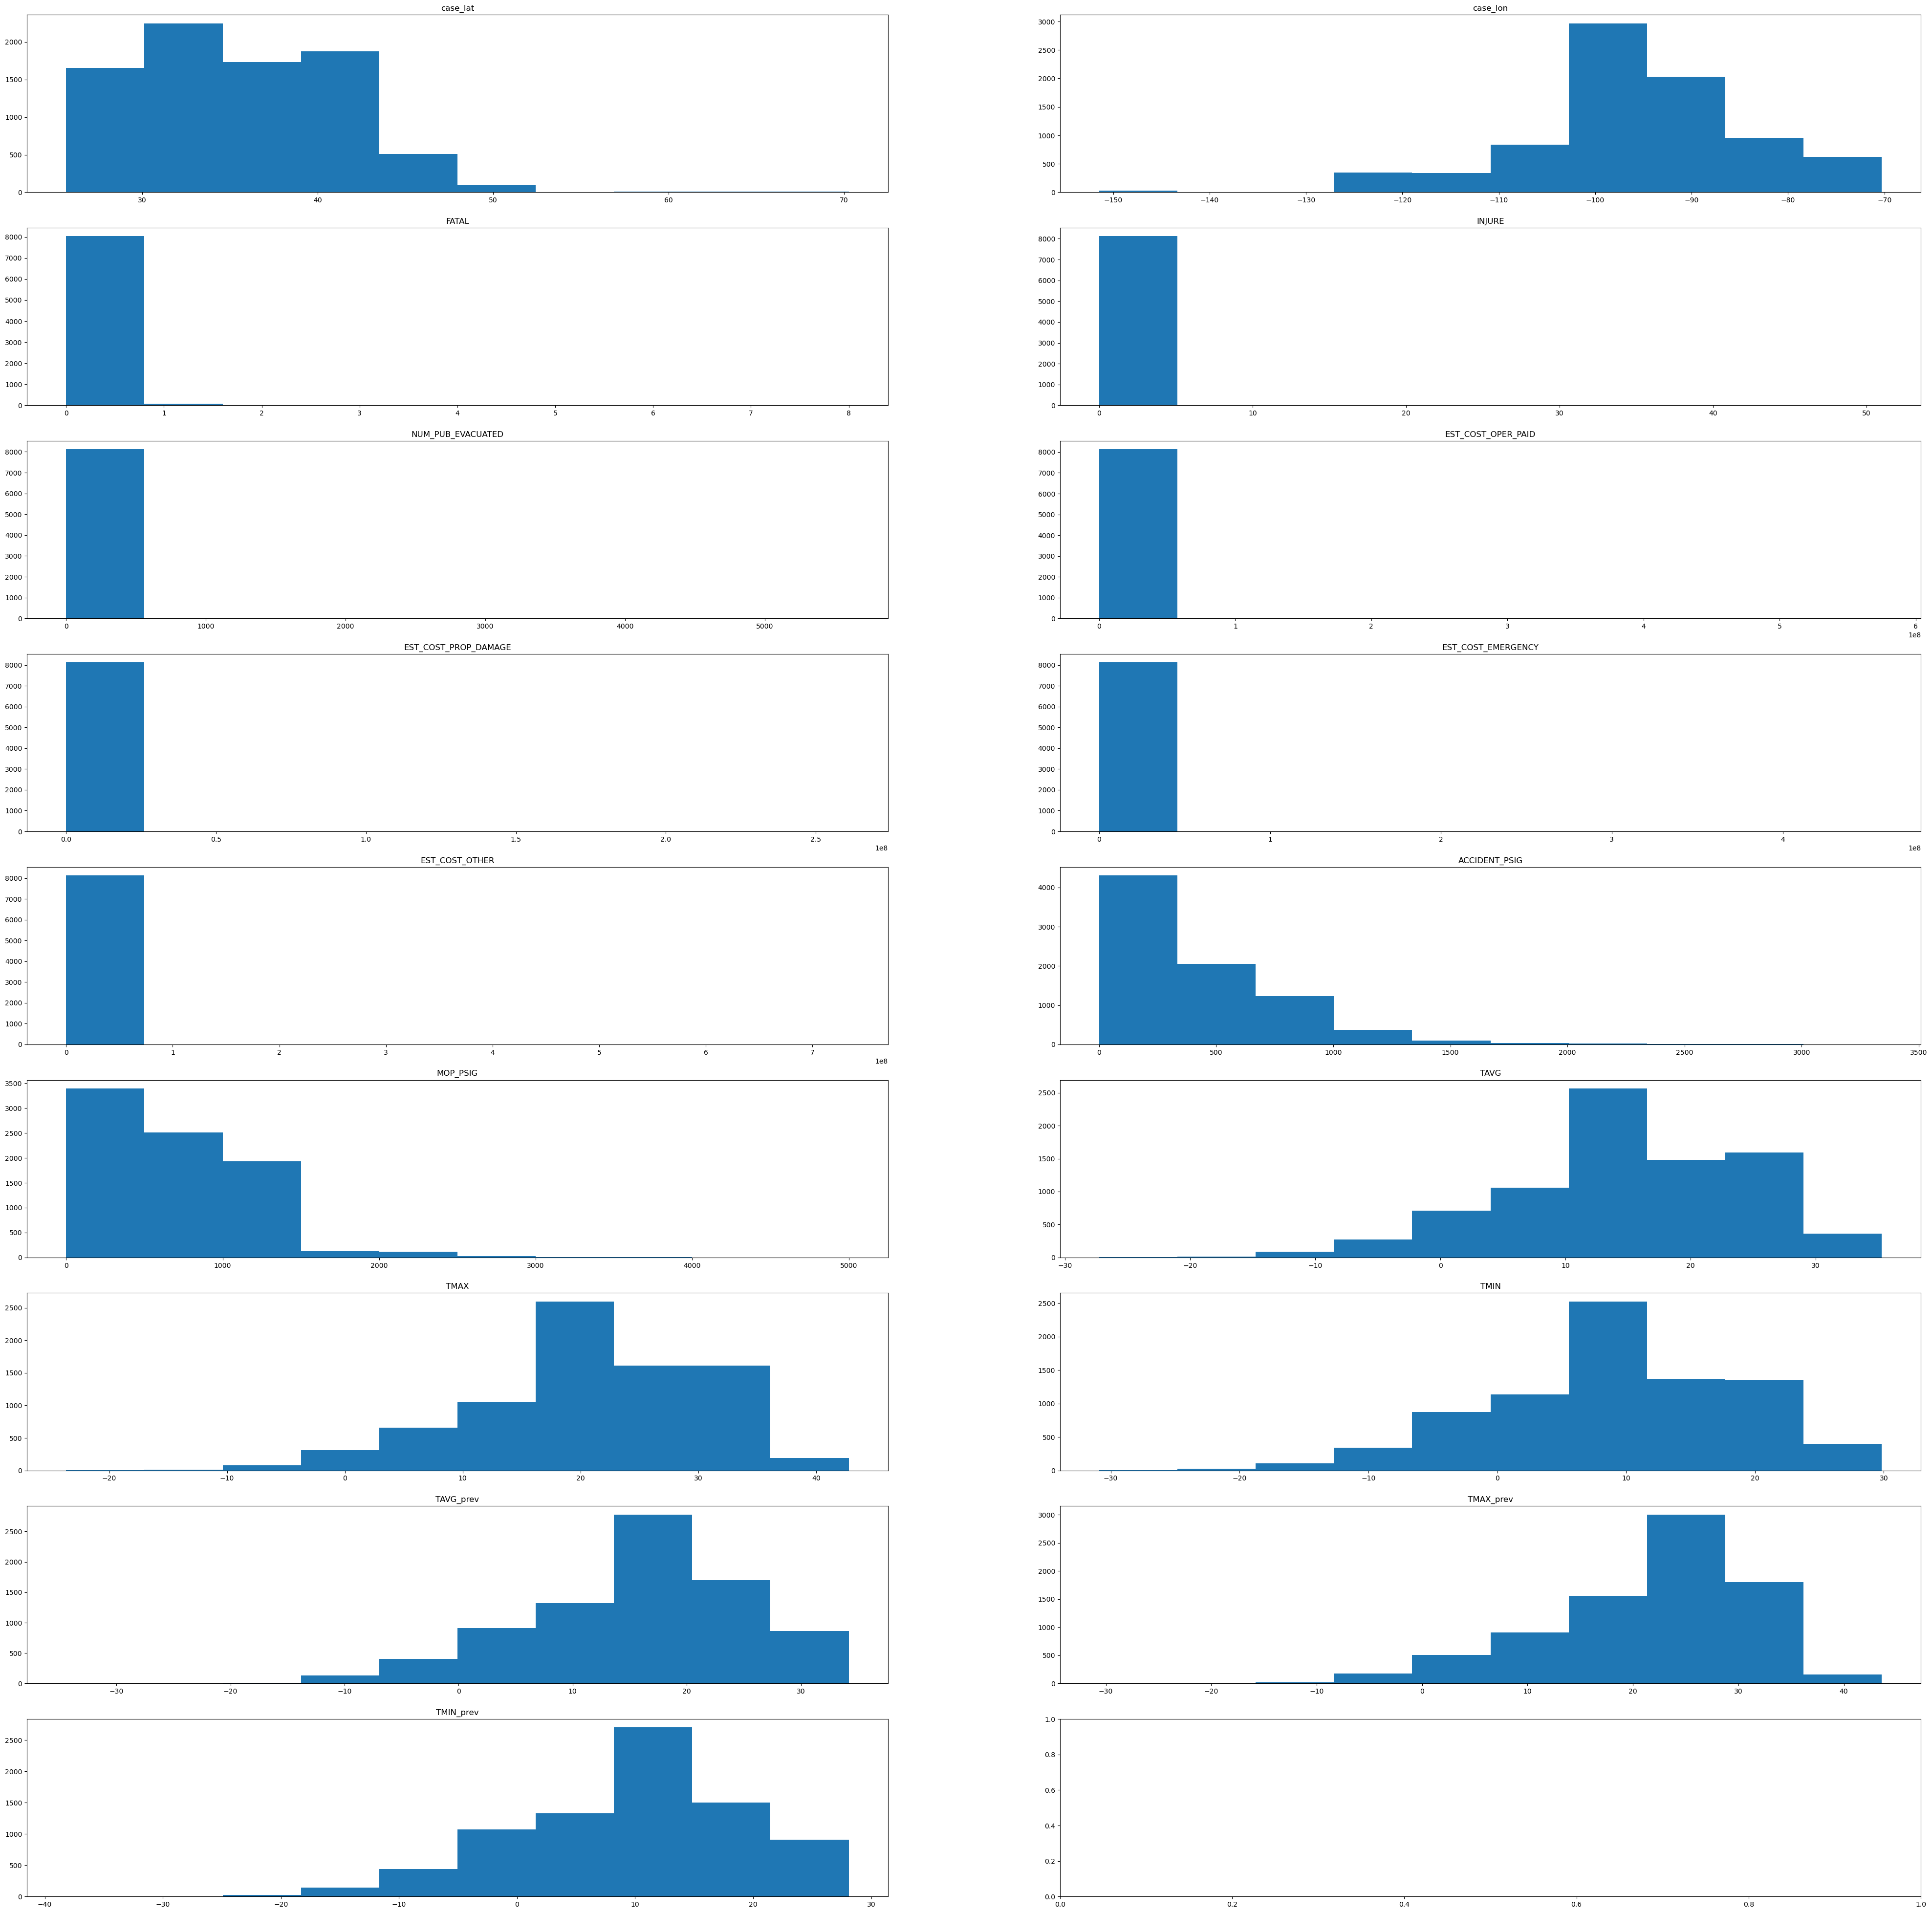

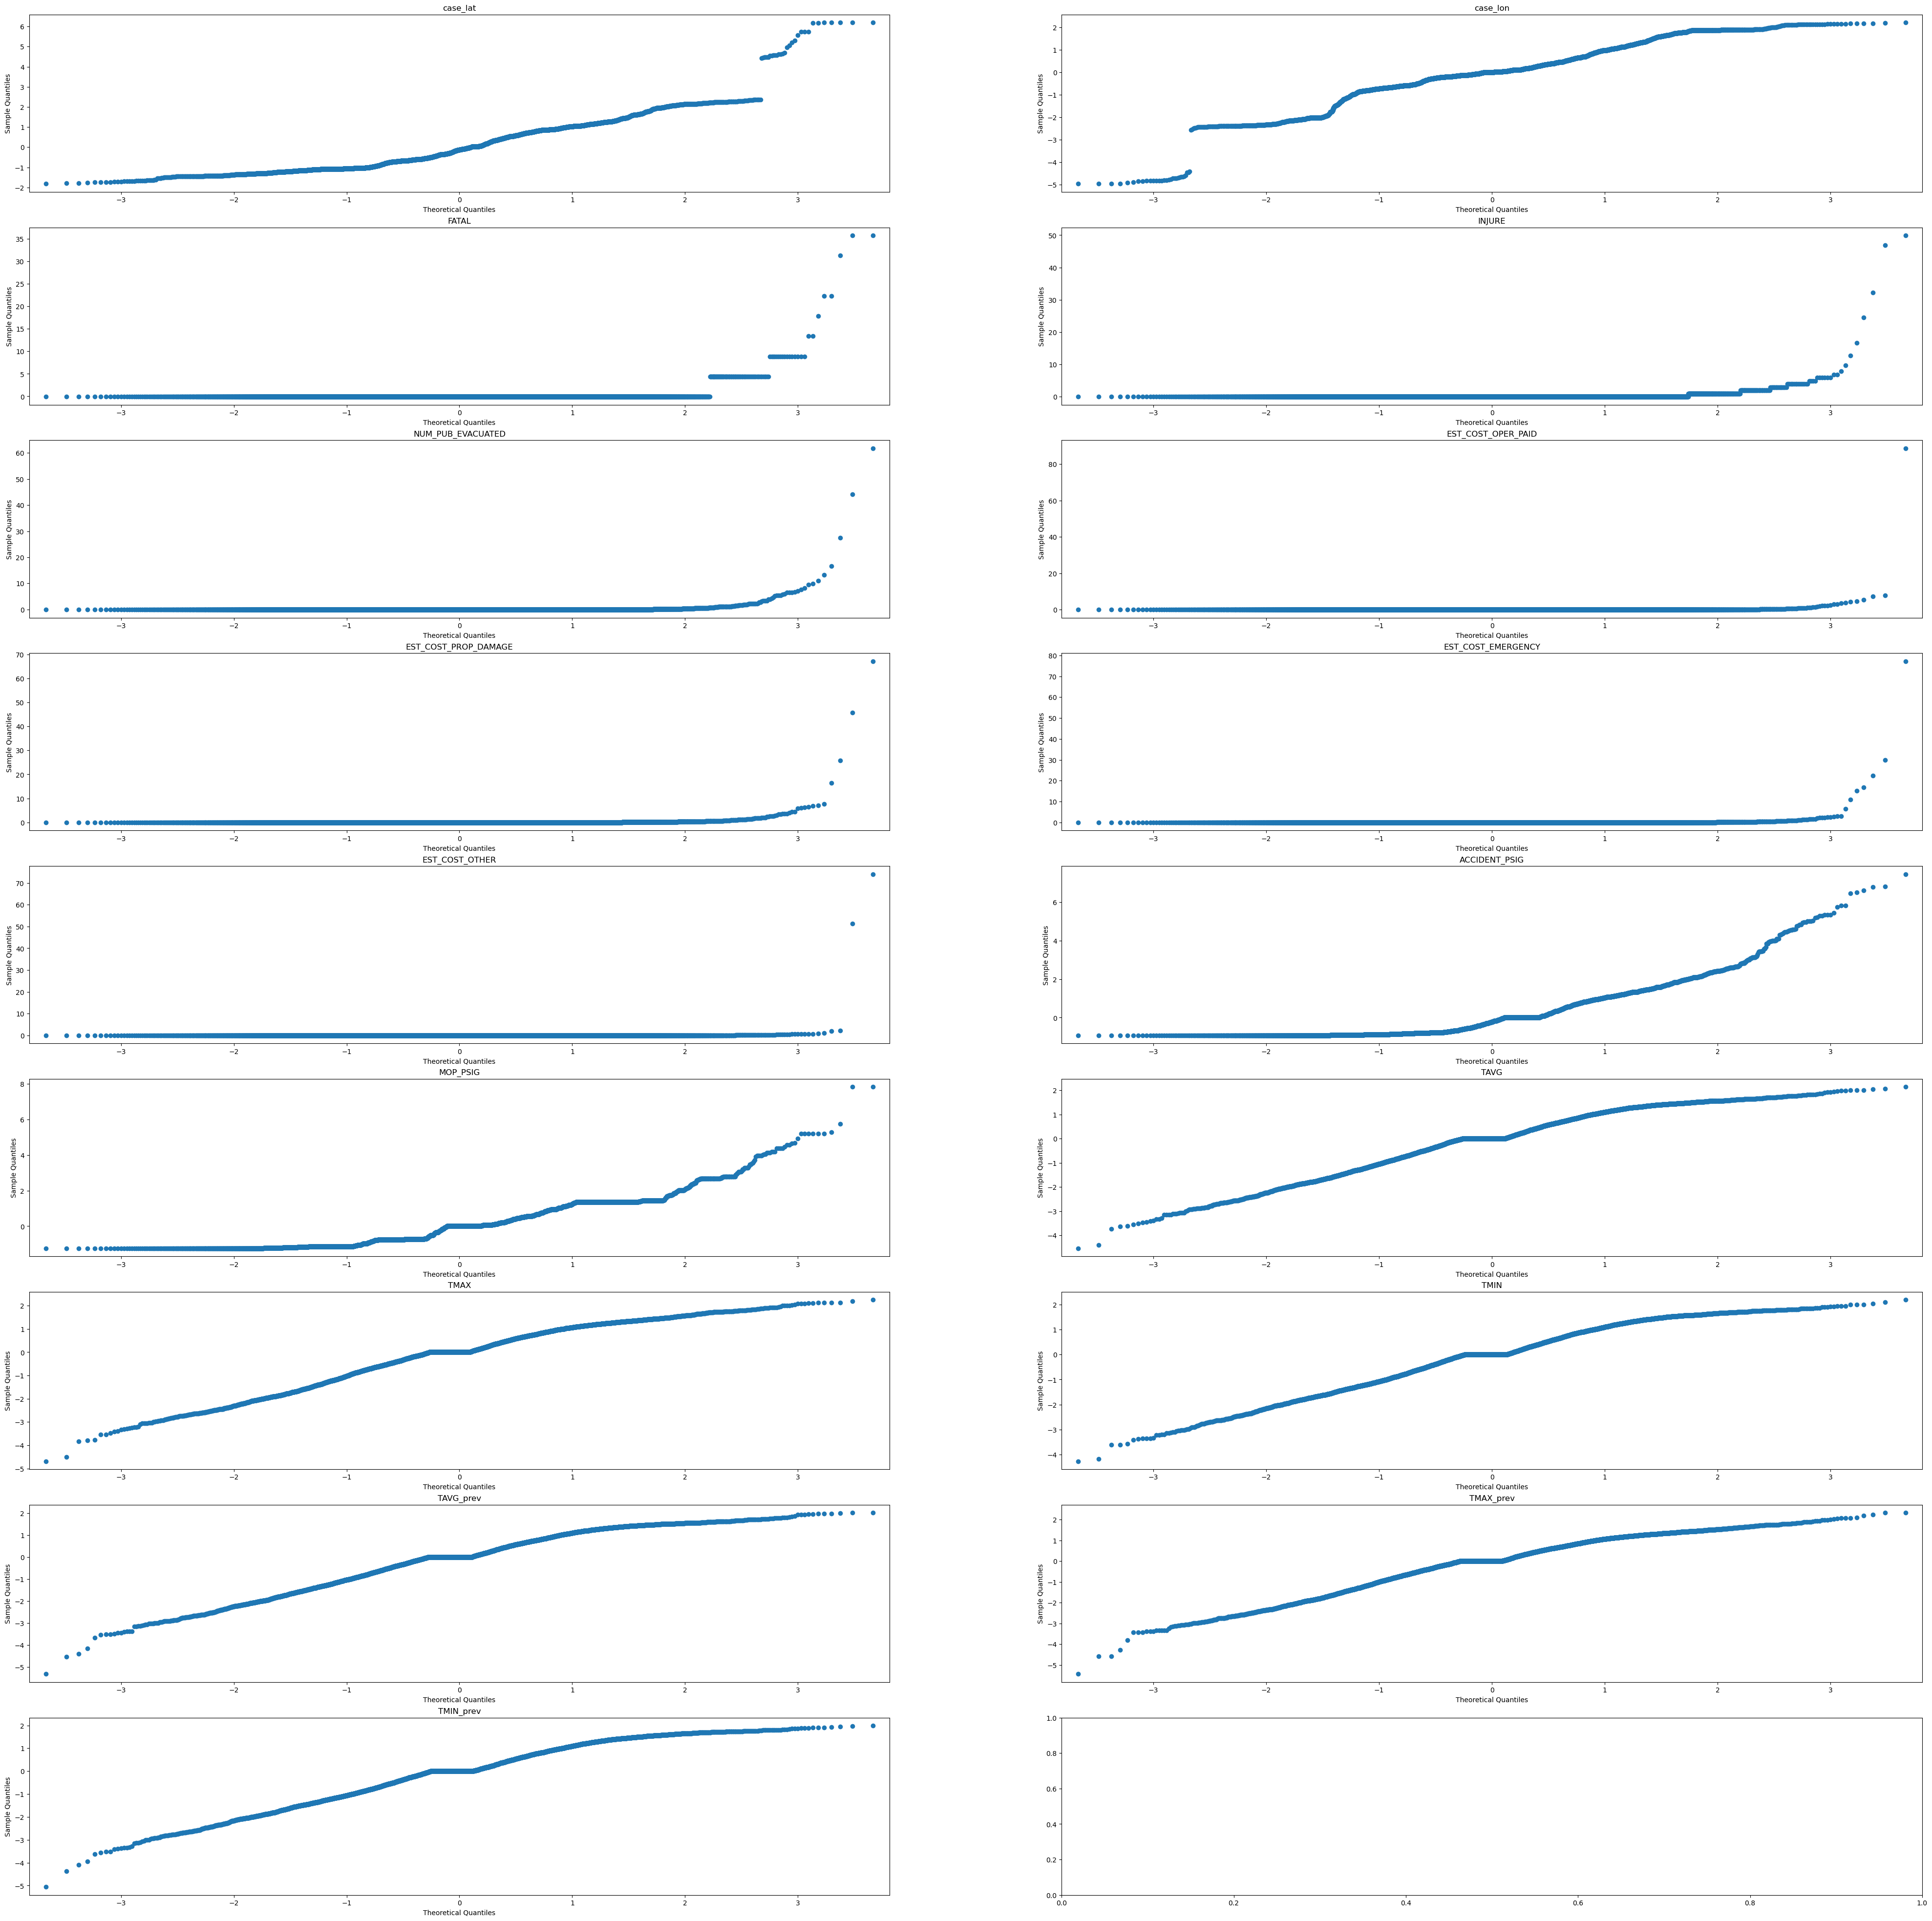

In [82]:
display_col_stats(df)

In [7]:
plt.matshow(df.corr())
plt.show()

ValueError: could not convert string to float: 'gravity'

In [ ]:
for num_col